# Toy problem: Learning LJ potential with three atoms

This notebook showcased the usage of PiNN with a toy problem of learning Lennard Jones
potential with a hand-generated dataset.  
It serves as a basic test, and demonstration of the workflow with PiNN.

In [1]:
%matplotlib inline

In [2]:
import os, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ase import Atoms
from ase.calculators.lj import LennardJones
os.environ['CUDA_VISIBLE_DEVICES'] = ''
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)
# Turn off the tf INFOs
tf.logging.set_verbosity('ERROR') 

## Reference data

In [3]:
# Helper function: get the position given PES dimension(s)
def three_body_sample(atoms, a, r):
    x = a * np.pi / 180
    pos = [[0, 0, 0],
           [0, 2, 0],
           [0, r*np.cos(x), r*np.sin(x)]]
    atoms.set_positions(pos)
    return atoms

In [4]:
atoms = Atoms('H3', calculator=LennardJones())

na, nr = 50, 50
arange = np.linspace(30,180,na)
rrange = np.linspace(1,3,nr)

# Truth
agrid, rgrid = np.meshgrid(arange, rrange)
egrid = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        atoms = three_body_sample(atoms, arange[i], rrange[j])
        egrid[i,j] = atoms.get_potential_energy()
        
# Samples
nsample = 100
asample, rsample = [], []
distsample = []
data = {'e_data':[], 'f_data':[], 'elems':[], 'coord':[]}
for i in range(nsample):
    a, r = np.random.choice(arange), np.random.choice(rrange)
    atoms = three_body_sample(atoms, a, r)
    dist = atoms.get_all_distances()
    dist = dist[np.nonzero(dist)]
    data['e_data'].append(atoms.get_potential_energy())
    data['f_data'].append(atoms.get_forces())
    data['coord'].append(atoms.get_positions())
    data['elems'].append(atoms.numbers)
    asample.append(a)
    rsample.append(r)
    distsample.append(dist)

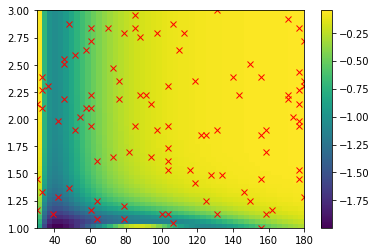

In [5]:
plt.pcolormesh(agrid, rgrid, egrid)
plt.plot(asample, rsample, 'rx')
plt.colorbar()

## Dataset from numpy arrays

In [6]:
from pinn.models import potential_model
from pinn.networks import pinn_network
from pinn.io import sparse_batch, load_numpy
from pinn.calculator import PiNN_calc

In [7]:
data = {k:np.array(v) for k,v in data.items()}
dataset = lambda: load_numpy(data)

train = lambda: dataset()['train'].shuffle(100).repeat().apply(sparse_batch(100))
test = lambda: dataset()['test'].repeat().apply(sparse_batch(100))

# Training

## Model specification

In [8]:
params={
    'model_dir': '/tmp/toy_models/LJ_three_body_2',
    'network': 'pinn_network',
    'network_params': {
        'ii_nodes':[8,8],
        'pi_nodes':[8,8],
        'pp_nodes':[8,8],
        'en_nodes':[8,8],
        'depth': 4,
        'rc': 3.0,
        'atom_types':[1]},
    'model_params':{
        'e_dress': {1:-0.3},  # element-specific energy dress
        'e_scale': 2, # energy scale for prediction
        'e_unit': 1.0,  # output unit of energy dur
        'log_e_per_atom': True, # log e_per_atom and its distribution    
        'use_force': True,      # include force in Loss functiona
        
}}
model = potential_model(params)

In [9]:
#%rm -r /tmp/toy_models/LJ_three_body/ # Uncomment to trash previous model
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=5e3)
eval_spec = tf.estimator.EvalSpec(input_fn=test, steps=10)
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Total number of trainable variables: 3144


({'METRICS/E_LOSS': 0.00025793674,
  'METRICS/E_MAE': 0.011850489,
  'METRICS/E_RMSE': 0.01606041,
  'METRICS/TOT_LOSS': 0.0141722355,
  'loss': 0.0141722355,
  'global_step': 5000},
 [])

## Validate the results
### PES analysis

In [12]:
atoms = Atoms('H3', calculator=PiNN_calc(model))
epred = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        a, r = arange[i], rrange[j]
        atoms = three_body_sample(atoms, a, r)
        epred[i,j] = atoms.get_potential_energy()

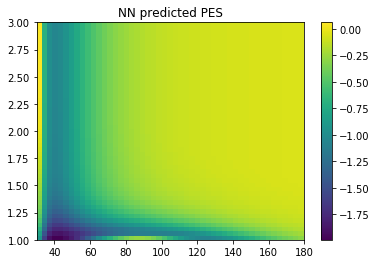

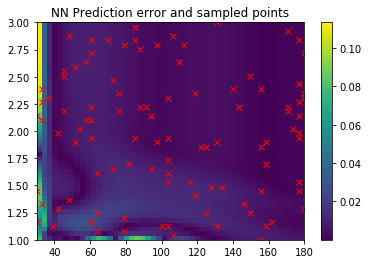

In [13]:
plt.pcolormesh(agrid, rgrid, epred)
plt.colorbar()
plt.title('NN predicted PES')
plt.figure()
plt.pcolormesh(agrid, rgrid, np.abs(egrid-epred))
plt.plot(asample, rsample, 'rx')
plt.title('NN Prediction error and sampled points')
plt.colorbar()

### Pairwise potential analysis

In [14]:
atoms1 = Atoms('H2', calculator=PiNN_calc(model))
atoms2 = Atoms('H2', calculator=LennardJones())

nr2 = 100
rrange2 = np.linspace(1,1.9,nr2)
epred = np.zeros(nr2)
etrue = np.zeros(nr2)

for i in range(nr2):
    pos = [[0, 0, 0],
           [rrange2[i], 0, 0]]
    atoms1.set_positions(pos)
    atoms2.set_positions(pos)
    epred[i] = atoms1.get_potential_energy()
    etrue[i] = atoms2.get_potential_energy()

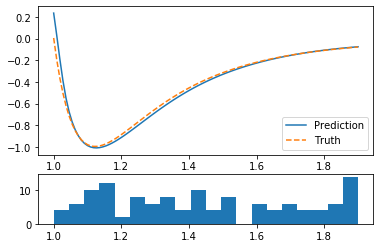

In [15]:
f, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.plot(rrange2, epred)
ax1.plot(rrange2, etrue,'--')
ax1.legend(['Prediction', 'Truth'], loc=4)
_=ax2.hist(np.concatenate(distsample,0), 20, range=(1,1.9))